Author: Alonso Menéndez González

This notebook contains the code necessary to prepare the datasets and manage the model, comprising the First and Second step in the Fault Detection System. Specifically, this code was made for the IMS dataset, but with minor adjustments, it could be reused for any dataset.

First, the dataset is loaded and the model is defined in a Class, which will be later extended to include the training loop. Afterwards, it is trained using the selected dataset's healthy samples, process monitorized by using wandb. Finally, after the model has finished learning from the healthy distributions, it is asked to predict the mean and variances of the whole dataset, which are saved for the next step in the Fault Detection System.

**Please note:** This code was written as a Google Colab Notebook that uses Weights & Biases. Therefore, several changes must be made before executing it.

**Table of contents**<a id='toc0_'></a>    
- [Imports and installations](#toc1_1_)    
- [Dataset](#toc2_)    
  - [Custom Dataset for IMS1](#toc2_1_)    
  - [Getting a sample](#toc2_2_)    
- [Model Definition](#toc3_)    
  - [Encoder](#toc3_1_)    
    - [Test](#toc3_1_1_)    
  - [Decoder](#toc3_2_)    
    - [Test](#toc3_2_1_)    
  - [LogLikelihood](#toc3_3_)    
    - [Test](#toc3_3_1_)    
  - [VAE class](#toc3_4_)    
    - [Test](#toc3_4_1_)    
  - [Training Loop](#toc3_5_)    
- [Train Model](#toc4_)    
- [Test model](#toc5_)    
- [Test Model (Larger Z size)](#toc6_)    
  - [Distributions](#toc6_1_)    
  - [Histogram](#toc6_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Imports and installations](#toc0_)
Packages, libraries and wandb key setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


In [ ]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import wandb
import os
from google.colab import userdata
import pandas as pd
import numpy as np
import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim

import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
wandb_key = userdata.get('wandb')

In [ ]:
wandb.login(key=wandb_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# <a id='toc2_'></a>[Dataset](#toc0_)
Preparation of the CustomDataset class

In [ ]:
csv_directory = "/content/drive/MyDrive/TFM/IMS/set_1" # Path to the folder containing the datasets. Expects to find several csv files.
coi = 2 # Dont confuse with channels, which are 1-indexed

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, coi, partitions=1,top=300):
      """
      folder_path: Path to the folder containing the dataset. Expects to find several csv files in it. 
      coi: index of the Column Of Interest. (Mainly, the one corresponding to the channel most related to the fault)
      partitions: if each file is too big (memory limitations), consider increasing this number to split them into smaller chunks. Default 1.
      top: number of files to consider as healthy (only get the top n files). Default 300.
      """
      self.folder_path = folder_path
      self.file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)][:top]
      self.partitions = partitions
      self.coi=coi

    def __len__(self):
        return len(self.file_paths) * self.partitions

    def __getitem__(self, index):
        file_index = index // self.partitions
        part_index = index % self.partitions

        file_path = self.file_paths[file_index]
        df = pd.read_csv(file_path,sep="\t", header=None).iloc[:,self.coi]
        chunks = np.array_split(df, self.partitions)
        data = chunks[part_index]
        tensor = torch.Tensor(data.values)
        return tensor

In [ ]:
dataset = CustomDataset(folder_path=csv_directory, coi=coi) # As top is 300, this is the "training dataset"

In [ ]:
len(dataset) # Should be the same as "top"

300

In [ ]:
batch_size = 8 # Careful with big datasets and memory available

In [ ]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) #Ready for use!

## <a id='toc2_1_'></a>[Custom Dataset for IMS1](#toc0_)
Alternative dataset for IMS1. This code was used to load several columns at the same time, aiming to improve the results by taking into account several channels that might be related to the fault.

In [ ]:
csv_directory = "/content/drive/MyDrive/TFM/IMS/set_1"
#col_names = ["Ch1","Ch2","Ch3","Ch4","Ch5","Ch6","Ch7","Ch8"]

In [ ]:
class CustomDatasetIMS1(Dataset):
    def __init__(self, folder_path, partitions=1,top=300):
      """
      top: number of files to consider as healthy (only get the top n files)
      """
      self.folder_path = folder_path
      self.file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)][:top]
      self.partitions = partitions

    def __len__(self):
        return len(self.file_paths) * self.partitions

    def __getitem__(self, index):
        file_index = index // self.partitions
        part_index = index % self.partitions

        file_path = self.file_paths[file_index]
        df = pd.read_csv(file_path,sep="\t", header=None).iloc[:,4:] # <- This ".iloc[:,4:] controls the columns selected. Basically replaces the coi"
        chunks = np.array_split(df, self.partitions)
        data = chunks[part_index]
        tensor = torch.Tensor(data.values)
        tensor = torch.flatten(tensor)
        return tensor

In [ ]:
dataset = CustomDatasetIMS1(folder_path=csv_directory)

In [ ]:
len(dataset)

300

In [ ]:
batch_size = 2 # Be even more careful with memory usage, as more columns are being added.

In [ ]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## <a id='toc2_2_'></a>[Getting a sample](#toc0_)
Run this code to get the "train" iterator and "input_size"

In [ ]:
train = iter(dataloader)

In [ ]:
i = next(train)

In [ ]:
i.shape

torch.Size([2, 81920])

In [ ]:
#input_size = i.shape[1] * i.shape[2]
#input_size = 20480 * 8

In [ ]:
input_size = i.shape[1]

# <a id='toc3_'></a>[Model Definition](#toc0_)
Contains all the necessary classes to build the VAE_extended class. Each section contains small tests that were used during development.

## <a id='toc3_1_'></a>[Encoder](#toc0_)

In [ ]:
class encoder(nn.Module):

    def __init__(self, dimz, input_size):


        super().__init__()

        self.dimz = dimz    #dimz is k, the dimension of the latent space

        self.linear1 = nn.Linear(input_size, 3500)
        self.linear2 = nn.Linear(3500, 700)
        self.linear3 = nn.Linear(700, 200)
        self.linear4 = nn.Linear(200,10)
        self.linear5 = nn.Linear(10,dimz*2)

        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()



    def forward(self,x):

        z = torch.flatten(x, start_dim=1)

        z = self.relu(self.linear1(z))
        z = self.relu(self.linear2(z))
        z = self.relu(self.linear3(z))
        z = self.relu(self.linear4(z))



        z = self.linear5(z)

        return z

    def encode_and_sample(self,x,flag_sample=True):

        # This methods compute both the posterior mean and variance
        # Also we obtain a sample from the posterior using the
        # reparameterization trick.

        # We obtain the encoder projection using the forward method

        z = self.forward(x)

        # The mean is the first dimz components of the forward output

        #mu = torch.clamp(z[:,:self.dimz], min=0.0) # Monotonic
        mu = z[:,:self.dimz]

        # We compute the variance from the last dimz components using a
        # soft plus
        var = self.softplus(0.5 * z[:, self.dimz:])

        sample = None

        if(flag_sample==True):

            eps = torch.randn_like(var)

            sample = mu + eps*(var**0.5)

        return mu,var,sample

### <a id='toc3_1_1_'></a>[Test](#toc0_)

In [ ]:
#enc = encoder(dimz=2,input_size=input_size)
#mu_z, var_z, sample = enc.encode_and_sample(x=i)

In [ ]:
#mu_z

## <a id='toc3_2_'></a>[Decoder](#toc0_)

In [ ]:
class decoder(nn.Module):

    def __init__(self, dimz, output_size):


        super().__init__()

        self.dimz = dimz    #dimz is k, the dimension of the latent space

        self.linear1 = nn.Linear(dimz,10)
        self.linear2 = nn.Linear(10,200)
        self.linear3 = nn.Linear(200,700)
        self.linear4 = nn.Linear(700,3500)
        self.linear5 = nn.Linear(3500,output_size)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()



    def forward(self,z):

        z = self.relu(self.linear1(z))
        z = self.relu(self.linear2(z))
        z = self.relu(self.linear3(z))
        z = self.relu(self.linear4(z))
        x = self.tanh(self.linear5(z))

        return x

    def decode(self,z):

        return self.forward(z)

### <a id='toc3_2_1_'></a>[Test](#toc0_)

In [ ]:
#dec = decoder(dimz=2,output_size=input_size)
#x_mean = dec.decode(mu_z).detach()

In [ ]:
#x_mean.shape

In [ ]:
#x_mean.reshape(batch_size,-1)

## <a id='toc3_3_'></a>[LogLikelihood](#toc0_)

In [ ]:
def eval_Gaussian_LL(x,mu_x,var_x):

    # x is a mini-batch of data. It has dimension [Batch,n_recordings,n_sensors]

    # mu_x is a mini-batch of reconstructed images. It has dimension [Batch,n_recordings,n_sensors]

    # var_x is a torch constant

    D = x.shape[1] # Dimension of the image

    x = x.reshape(-1, D)

    mu_x = mu_x.reshape(-1, D)

    var_x = torch.ones_like(mu_x) * var_x

    # Constant term in the gaussian distribution
    cnt = D * np.log(2 * np.pi) + torch.sum(torch.log(var_x), dim=-1)

    # log-likelihood per datapoint

    logp_data = -0.5 * (cnt + torch.sum((x - mu_x) * var_x ** -1 * (x - mu_x), dim=-1))

    # Accumulated Gaussian log-likelihood for all datapoints in the batch
    logp = torch.sum(logp_data)

    return logp,logp_data

### <a id='toc3_3_1_'></a>[Test](#toc0_)

In [ ]:
#var_x = 0.1
#
#logp,logp_data = eval_Gaussian_LL(i,x_mean,var_x)
#
#print(logp)
#
#plt.plot(np.arange(0,batch_size),logp_data)

## <a id='toc3_4_'></a>[VAE class](#toc0_)

In [ ]:
class VAE(nn.Module):

    def __init__(self,dimz,input_size,var_x=0.1):

        super().__init__()

        self.var_x = var_x

        self.dimz = dimz
        self.input_size = input_size

        # We create an encoder network

        self.encoder = encoder(self.dimz, self.input_size)

        # We create a decoder network

        self.decoder = decoder(self.dimz, self.input_size)

    def forward(self,x):

        # In the forward method, we return the mean and variance
        # given by the encoder network and also the reconstruction mean
        # given by the decoder network using a sample from the
        # encoder's posterior distribution.

        mu_z,var_z,sample_z = self.encoder.encode_and_sample(x=x)

        # Decoder provides the mean of the reconstruction

        mu_x = self.decoder.decode(sample_z)

        return mu_x,mu_z,var_z

    # Reconstruction + KL divergence losses summed over all elements and batch

    def loss_function(self, x, mu_x, mu_z, var_z):

        # We evaluate the loglikelihood in the batch using the function provided above

        logp,_ = eval_Gaussian_LL(x, mu_x, torch.tensor(0.1))

        # KL divergence between q(z) and N()
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114

        KLz = -0.5 * torch.sum(1 + torch.log(var_z) - mu_z.pow(2) - var_z)

        # To maximize ELBO we minimize loss (-ELBO)
        return -logp + KLz, -logp, KLz

### <a id='toc3_4_1_'></a>[Test](#toc0_)

In [ ]:
#my_vae = VAE(dimz=2,input_size=input_size)

In [ ]:
#print(my_vae.loss_function(i,x_mean,mu_z,var_z))

## <a id='toc3_5_'></a>[Training Loop](#toc0_)

In [ ]:
class VAE_extended(VAE):

    def __init__(self,name,notes,
                 dimz=2,  input_size=3, var_x=0.1,lr=1e-3,epochs=20,
                 save_folder='/content/drive/MyDrive/TFM/models/',restore=False,
                 ):
        """
        dimz: Size of the latent space. Note that size 1 means that dimz will be 1 pair of values (mean & variance)
        save_folder: The model will be saved from time to time while training in this location in a file called "<name>.pth"
        restore: Set to True to resume the training from the specified .pth file.
        """

        super().__init__(dimz,input_size=input_size,var_x=var_x)

        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        self.save_folder = save_folder
        self.name = name

        if(restore==True):
            state_dict = torch.load(self.save_folder+self.name+'.pth')
            self.load_state_dict(state_dict)

        self.loss_during_training = []
        self.reconstruc_during_training = []
        self.KL_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)



        wandb.init(
          project="TFM",
          entity="healthcare-ai",
          name=name,
          notes=notes,
          config={
            "epochs": epochs,
            "layer_size": [input_size, 4000, 1000, 200, 50, dimz],
            "lr": lr,
            "var_x": var_x,
            })

    def trainloop(self,trainloader):

        nims = len(trainloader.dataset)

        self.train()

        for e in range(int(self.epochs)):

            train_loss = 0
            train_rec = 0
            train_kl_l = 0

            idx_batch = 0

            for items in trainloader:

                items = items.to(self.device)

                self.optim.zero_grad()

                mu_x, mu_z, var_z = self.forward(items)

                loss, rec, kl_l = self.loss_function(items,mu_x, mu_z, var_z)

                loss.backward()

                train_loss += loss.item()
                train_rec += rec.item()
                train_kl_l += kl_l.item()

                self.optim.step()

                if (idx_batch % (len(trainloader)//20) == 0):

                  print(f'Training: {idx_batch}/{len(trainloader)}')

                if(idx_batch%10==0):

                    torch.save(self.state_dict(), self.save_folder + self.name +'.pth')
                    #print(f'Train Batch: {idx_batch}')

                idx_batch += 1


            self.loss_during_training.append(train_loss/len(trainloader))
            self.reconstruc_during_training.append(train_rec/len(trainloader))
            self.KL_during_training.append(train_kl_l/len(trainloader))

            metrics = {"train/train_loss": train_loss/len(trainloader),
                       "train/train_reconstruction": train_rec/len(trainloader),
                       "train/train_kl_loss": train_kl_l/len(trainloader),
                       "train/epoch": e,
                       }

            wandb.log(metrics)

            if(e%1==0):

                torch.save(self.state_dict(), self.save_folder + self.name +'.pth')
                print('Train Epoch: {} \tLoss: {:.6f}'.format(e,self.loss_during_training[-1]))


    def sample(self,num_imgs):

        with torch.no_grad():

            eps = torch.randn([num_imgs,self.dimz]).to(self.device)

            x_sample = self.decoder.decode(eps)

            return x_sample.to("cpu").detach()

    def encode_and_sample_loop(self, dataloader, flag_sample=True):
      """


      parameters:
        dataloader: of a dataset. Careful with batch size.
        flag_sample: if true, a sample with mu and var will be computed.


      For each of the elements of dataloader, encode and obtain the following:
        mu_x: mean of the element, of size (batch_size, dimz)
        var_x: variance, same size
        sample: using the previous values, adquire a sample.
      """
      for items in dataloader:
        items = items.to(self.device)
        mu_x, var_x, sample = self.encoder.encode_and_sample(x=items,flag_sample=flag_sample)

        for row_index in range(mu_x.shape[0]):
          mu = mu_x[row_index].tolist()
          var = var_x[row_index].tolist()




          wandb.log({"mu0":mu[0],
                     "mu1":mu[1],
                     "mu2":mu[2],
                     "mu3":mu[3],
                     #"mu4":mu[4],
                     "var0":var[0],
                     "var1":var[1],
                     "var2":var[2],
                     "var3":var[3],
                     #"var4":var[4],
                     })






# <a id='toc4_'></a>[Train Model](#toc0_)
Code for training the model. First the class is initialized and the trainloop is executed afterwards.

Currently, an old test can be seen where a Size 8 latent space was being trained.

In [ ]:
my_vae_scratch = VAE_extended(name="VAE-IMS1-QuadZ-QuadChannel",
                              notes="Changed input to recieve both channels of bearing 3 and 4: Ch5, Ch6, Ch7 & Ch8",
                              dimz=4, epochs=200, lr=1e-5,
                              input_size=input_size, restore=False)

In [ ]:
my_vae_scratch.trainloop(dataloader)

Training: 0/150
Training: 7/150
Training: 14/150
Training: 21/150
Training: 28/150
Training: 35/150
Training: 42/150
Training: 49/150
Training: 56/150
Training: 63/150
Training: 70/150
Training: 77/150
Training: 84/150
Training: 91/150
Training: 98/150
Training: 105/150
Training: 112/150
Training: 119/150
Training: 126/150
Training: 133/150
Training: 140/150
Training: 147/150
Train Epoch: 0 	Loss: -26171.932357
Training: 0/150
Training: 7/150
Training: 14/150
Training: 21/150
Training: 28/150
Training: 35/150
Training: 42/150
Training: 49/150
Training: 56/150
Training: 63/150
Training: 70/150
Training: 77/150
Training: 84/150
Training: 91/150
Training: 98/150
Training: 105/150
Training: 112/150
Training: 119/150
Training: 126/150
Training: 133/150
Training: 140/150
Training: 147/150
Train Epoch: 1 	Loss: -29552.126953
Training: 0/150
Training: 7/150
Training: 14/150
Training: 21/150
Training: 28/150
Training: 35/150
Training: 42/150
Training: 49/150
Training: 56/150
Training: 63/150
Tr

In [ ]:
for i in train_dataloader
  print(i)
  break

tensor([[[-0.1030, -0.0200,  0.0240,  ..., -0.1880, -0.2860, -0.1070],
         [-0.0680, -0.0680, -0.0150,  ..., -0.0070, -0.1760, -0.2590],
         [-0.0590,  0.1290, -0.0630,  ..., -0.0390, -0.1270, -0.2120],
         ...,
         [-0.1440, -0.1490, -0.1590,  ..., -0.0880, -0.1050, -0.2250],
         [-0.1540, -0.0780, -0.0610,  ..., -0.0930, -0.0490, -0.1710],
         [-0.0950, -0.0320, -0.2100,  ..., -0.3520, -0.1610, -0.1200]]])


# <a id='toc5_'></a>[Test model](#toc0_)
Obtain predictions of Means and Variances. **Only 1** column of interest.

In [ ]:
dataset = CustomDataset(folder_path=csv_directory, coi=2, top=-1)

In [ ]:
len(dataset)

6323

In [ ]:
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

In [ ]:
dataloader = iter(dataloader)

In [ ]:
len(dataloader)

791

In [ ]:
my_vae_scratch = VAE_extended(name="VAE-IMS3-SingleZ-NoClamp",
                              notes="Drawing histograms",
                              dimz=1, epochs=0, lr=1e-5,
                              input_size=input_size, restore=True)

In [ ]:
# If the following block fails, uncomment this line and try again
# my_vae_scratch.encode_and_sample_loop(dataloader=dataloader,flag_sample=False)

In [ ]:
res = pd.DataFrame(columns=["mu_x","var_x"])

for items in dataloader:
        items = items.to(my_vae_scratch.device)
        mu_x, var_x, sample = my_vae_scratch.encoder.encode_and_sample(x=items)
        df = pd.DataFrame({
            'mu_x': sum(mu_x.tolist(), []),
            'var_x': sum(var_x.tolist(), []),
        })

        res = pd.concat([res,df], ignore_index=True)


In [ ]:
res

,mu_x,var_x
0,-2.213646,0.006136
1,-2.205960,0.005577
2,0.207786,0.003278
3,-1.623015,0.012581
4,-2.380131,0.002658
...,...,...
6318,-2.079853,0.014700
6319,-2.117157,0.006642
6320,1.900596,0.008418
6321,-1.190425,0.005771


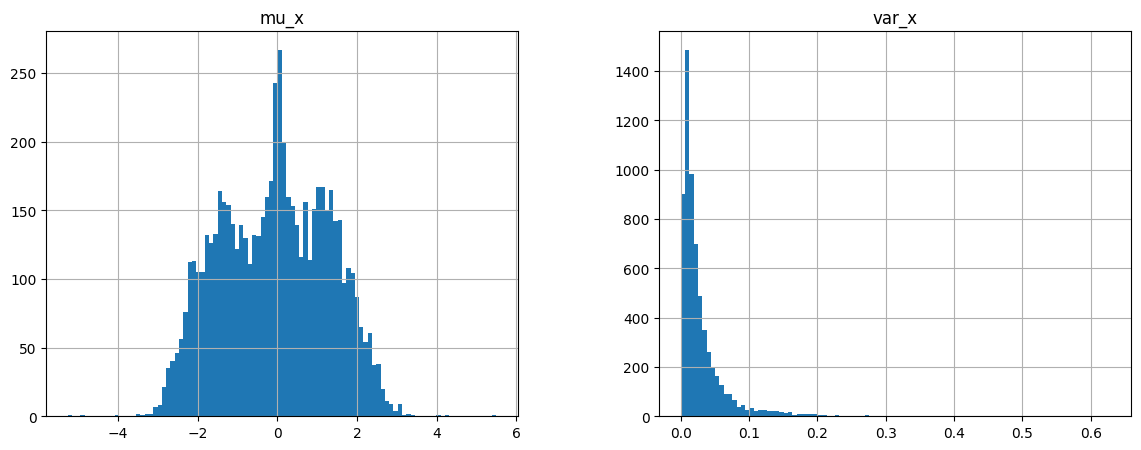

In [ ]:
res.hist(bins=100, figsize=(14, 5))  # Adjust the number of bins and figure size as needed
plt.show()

In [ ]:
res.to_csv("IMS-3-mean-var.csv")

# <a id='toc6_'></a>[Test Model (Larger Z size)](#toc0_)
Alternative code that I used for IMS1, but only to test the VAE capabilities when dealing with a larger latent space

## <a id='toc6_1_'></a>[Distributions](#toc0_)
Can be ommited

In [ ]:
dataset = CustomDatasetIMS1(folder_path=csv_directory, top=-1)

In [ ]:
len(dataset)

2155

In [ ]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

In [ ]:
dataloader = iter(dataloader)

In [ ]:
len(dataloader)

1078

In [ ]:
my_vae_scratch = VAE_extended(name="VAE-IMS1-QuadZ-QuadChannel",
                              notes="Drawing histograms",
                              dimz=4, epochs=0, lr=1e-5,
                              input_size=input_size, restore=True)

In [ ]:
my_vae_scratch.encode_and_sample_loop(dataloader=dataloader,flag_sample=False)

## <a id='toc6_2_'></a>[Histogram](#toc0_)

In [ ]:
dataset = CustomDatasetIMS1(folder_path=csv_directory, top=-1)

In [ ]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

In [ ]:
dataloader = iter(dataloader)

In [ ]:
res = pd.DataFrame(columns=["mu1","mu2","mu3","mu4","var1","var2","var3","var4"])

for items in dataloader:
        items = items.to(my_vae_scratch.device)
        mu_x, var_x, sample = my_vae_scratch.encoder.encode_and_sample(x=items)

        mu_df = pd.DataFrame(mu_x.tolist(), columns=["mu1","mu2","mu3","mu4"])
        var_df= pd.DataFrame(var_x.tolist(), columns=["var1","var2","var3","var4"])

        df = pd.concat([mu_df, var_df], axis=1)

        res = pd.concat([res,df], ignore_index=True)


In [ ]:
res

,mu1,mu2,mu3,mu4,var1,var2,var3,var4
0,-0.193404,1.535313,0.046028,-0.297995,1.009958,0.661254,1.084072,0.700019
1,-0.188741,1.521325,0.046322,-0.291591,1.006979,0.660956,1.079586,0.700779
2,-0.190799,1.528609,0.044820,-0.295673,1.008341,0.661304,1.081936,0.700121
3,-0.189093,1.519636,0.052712,-0.287594,1.007302,0.659621,1.079292,0.701626
4,-0.202746,1.559829,0.051793,-0.305938,1.015935,0.660615,1.092100,0.699590
...,...,...,...,...,...,...,...,...
2150,-0.106953,1.299037,-0.011351,-0.220990,0.954134,0.669632,1.006911,0.706197
2151,-0.194736,1.537068,0.050658,-0.296404,1.010853,0.660371,1.084788,0.700522
2152,-0.107631,1.301549,-0.012061,-0.222496,0.954569,0.669791,1.007684,0.705944
2153,-0.106618,1.298154,-0.011470,-0.220663,0.953933,0.669632,1.006642,0.706217


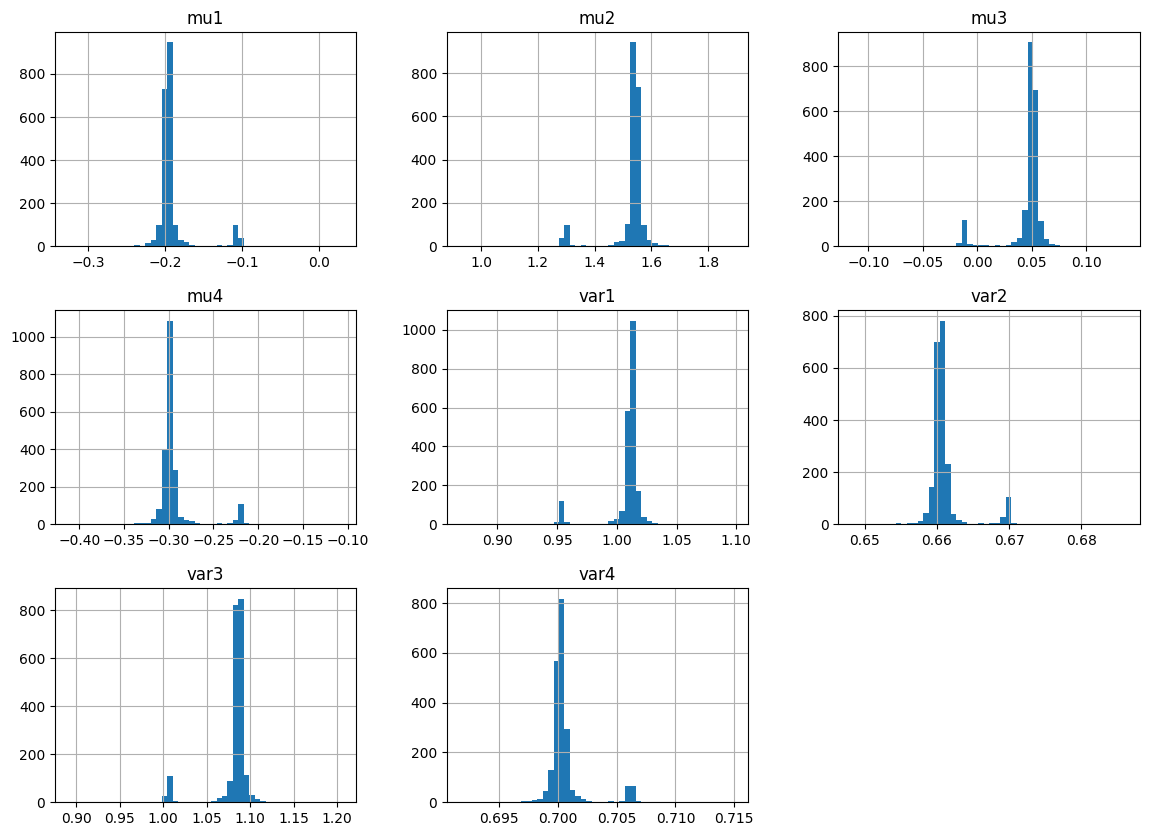

In [ ]:
res.hist(bins=50, figsize=(14, 10))  # Adjust the number of bins and figure size as needed
plt.show()

In [ ]:
res.to_csv("/content/drive/MyDrive/TFM/MeanVars/IMS-1-Quadz-QuadChannel-mean-var.csv")